# Interpolators with "decay" in HARK

## Preliminaries

Suppose we have an interpolator $f(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$ that is set up over a cartesian grid. Denote the greatest points of the i-th dimension grid with $\bar{x}_i$. Suppose we have some limiting function $g(\cdot): \mathbb{R}^n\rightarrow \mathbb{R}$ and we want to construct some enhanced function $h(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$ such that:
- $h(x) = f(x)$ when $x$ falls inside of the limits of $f$'s grids, that is $x_i \leq \bar{x}_i$ $\forall i=1,...,n$.
- $h(x)\rightarrow g(x)$ when $x\rightarrow\infty$ in any of its dimensions.

We might want to construct such functions if we are worried about the performance of our interpolator $f(\cdot)$ when approximating values that fall far-off its grid. As demonstrated in Section 5.10 of ["Solution Methods for Microeconomic Dynamic Stochastic Optimization Problems"](https://llorracc.github.io/SolvingMicroDSOPs/) this situation arises when approximating the solution of consumption-saving problems: extrapolated solutions can have characteristics that are at odds with the basic theoretical properties of our problems. Fortunately, it is often possible to analytically solve the limiting version of these problems---for instance a version of a consumption-saving problem where wealth is infinitely larger than income---and to use these analytical solutions $g(\cdot)$ to moderate the extrapolating behavior of our numerical solutions.

This notebook exemplifies the use of HARK's `econforgeinterp.DecayInterp` class, which implements n-dimensional interpolators that assymptotically approach a given analytical function off their grids.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from HARK.econforgeinterp import LinearFast, DecayInterp
from HARK.interpolation import LinearInterp

## Basic use of the `DecayInterp` class

`DecayInterp` requires two basic inputs:
- `interp`, which is the interpolator $f(\cdot)$. It must be an instance of the `HARK.econforgeinterp.LinearFast` class.
- `limit_fun`, which is the limiting function $g(\cdot)$. It must receive the same number of inputs as `interp` and be able to take `numpy` arrays as inputs.

And that's it!

### An example with a 2D function

Imagine an "$h(\cdot)$" type of function of two dimensions for which:
- $f(x,y) = 2*x + y$.
- $g(x,y) = \sqrt{x} + \sin(y)$.
The following cell creates a `DecayInterp` object representing such function.

In [2]:
# Construct the interpolator

# Grids
x_grid = np.linspace(0, 10, 11)
y_grid = np.linspace(0, 10, 11)
x, y = np.meshgrid(x_grid, y_grid, indexing="ij")
# Function value
z = 2 * x + y
# Create interpolator
interp = LinearFast(z, [x_grid, y_grid])

# Limit function


def lim_fun(x, y):
    return np.sqrt(x) - np.sin(y)


# Construct the interpolator with decay extrapolation (h function)
my_decay_interp = DecayInterp(
    interp=interp,
    limit_fun=lim_fun,
)

The following cell plots the function.

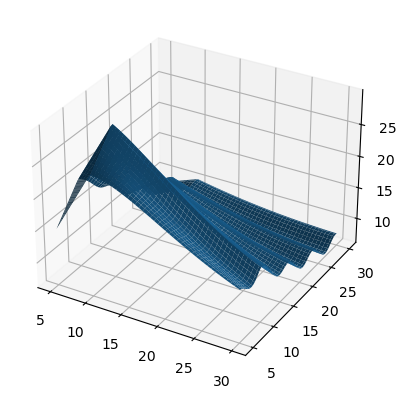

In [3]:
# Create some points to evaluate the function
x_ev, y_ev = np.meshgrid(
    np.linspace(5, 30, 100),
    np.linspace(5, 30, 100),
    indexing="ij",
)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_ev, y_ev, my_decay_interp(x_ev, y_ev))
plt.show()

Notice that the cell above defined $10$ as the greatest gridpoint in both dimensions $x$ and $y$. Therrefore, our plot should look like $2*x + y$ in the square $[0,10]^2$, and drift towards $\sqrt{x} + \sin(y)$ continuously when $x > 10$ or $y > 10$.

This is indeed the case, but there is a 'kink' that occurs along the $x=10$ and $y=10$ lines: the change in the behavior of the function is abrupt, and we might not want that depending on our application. If we want to avoid this sort of behavior, or control what happens in points that are outside the interpolator's grid but close to it, we have to tinker with the way in which we combine the $f(\cdot)$ and $g(\cdot)$ functions. `DecayInterp` refers to the way in which it combines the functions as its `decay_method`.

The class currently has three different decay methods:
- "`decay_prop`", the default.
- "`decay_hark`", which matches `HARK.interpolation.LinearInterp`'s decay method in the 1D case.
- "`paste`".

We now explain each method.

## `decay_method=="decay_prop"`

Imagine some $x$ that its outside of $f$'s grid in at least one dimension, that is, $\exists i\,\, x_i > \bar{x}_i$. Denote with $\tilde{x}$ the point in $\mathbb{R}^n$ that is inside the grid of $f$ and is closest to $x$; note that $\tilde{x} = \min\{x, \bar{x}\}$ with the minimum taken element-wise.

When `decay_method=="decay_prop"`, `DecayInterp` calculates a standardized distance between $x$ and $\tilde{x}$ as $$d(x, \tilde{x}) = \sum_{i=1}^n \left|  \frac{x_i - \tilde{x}_i}{\bar{x}_i} \right|$$ and uses it to compute the combination between the extrapolated value $f(x)$ and the limit value $g(x)$ as

\begin{equation}
h(x) = e^{-d(x,\tilde{x})} \times f(x) + (1 - e^{-d(x,\tilde{x})}) \times g(x)
\end{equation}

Notice that $f(x)$ is extrapolated using the provided interpolator. It's behavior will depend on the extrapolation options of the object you provide.

## `decay_method=="decay_hark"`

The method `"decay_hark"` is an N-dimensional generalization of the method used by HARK's 1D linear interpolators (`HARK.interpolation.LinearInterp`) when a limiting function is provided. This method tries to preserve the rate at which the approximated function $f(\cdot)$ approaches the limiting function $g(\cdot)$ when the edge of the grid is reached.

To explain this method intuitively, start with a one-dimensional case. Let $\bar{x}$ be the largest girdpoint and consider some $x>\bar{x}$.

We want the distance between functions $h(\cdot)$ and $g(\cdot)$ to close at a constant rate as we move along $x$. Calling that constant rate $K$ for now, this requirement can be expressed as
\begin{equation}
    \frac{d (g(x) - h(x))/d x}{g(x) - h(x)} = K.
\end{equation}
This is a simple differential equation with a known family of solutions of a form that we can express as
\begin{equation}
    g(x) - h(x) = A e^{K\times(x - \bar{x})}
\end{equation}
for any constant A.

Now we can obtain $A$ and $K$ from the restrictions we want to impose on our particular solution. First, we want $h(\bar{x})=f(\bar{x})$ so that there is no jump at the edge of the grid. This implies $$A = g(\bar{x}) - f(\bar{x}).$$

Finally, we want the rate of closing of the difference between the functions to be the same that it was exactly at the edge of the grid. That is
\begin{equation*}
    K = \left.\frac{d (g(x) - f(x))/d x}{g(x) - f(x)}\right|_{x=\bar{x}} = \frac{g'(\bar{x}) - f'(\bar{x})}{g(\bar{x}) - f(\bar{x})}
\end{equation*}

Putting everything together, we have
\begin{equation*}
    h(x) = g(x) - A\times e^{K\times(x - \bar{x})},\qquad A = g(\bar{x}) - f(\bar{x}) ,\qquad K = \frac{g'(\bar{x}) - f'(\bar{x})}{g(\bar{x}) - f(\bar{x})}
\end{equation*}

To ensure that $h(x)\rightarrow g(x)$ as $x\rightarrow\infty$, $K$ must be negative in the above expression, so we replace $K$ with $-|K|$.

The muliti-dimensional version of this interpolator simply replaces the expression for $K$ above with
\begin{equation*}
    K=\frac{1}{g(\bar{x}) - f(\bar{x})}\times(\nabla g(\bar{x}) - \nabla f(\bar{x})).
\end{equation*}

## `decay_method=="paste"`

The option `decay_method=="paste"` is different from the other two in the sense that it does not enforce $h(x)\rightarrow g(x)$ when $x\rightarrow\infty$. Instead, it "pastes" $g(\cdot)$ on top of $f(\cdot)$ so that, when extrapolating $h$ behaves like $g$ with a level shift that makes it coincide with $f$ at the edge of the grid. This is useful if we know that our function behaves like $g(\cdot)$ in the limit in its derivatives, but might not exactly coincide in levels.

Imagine some $x$ that its outside of $f$'s grid in at least one dimension, that is, $\exists i\,\, x_i > \bar{x}_i$. Denote with $\tilde{x}$ the point in $\mathbb{R}^n$ that is inside the grid of $f$ and is closest to $x$; note that $\tilde{x} = \min\{x, \bar{x}\}$ with the minimum taken element-wise. `DecayInterp` will return

$$
h(x) = g(x) + (f(\bar{x}) - g(\bar{x})).
$$

## An ilustration of the different "decay methods"

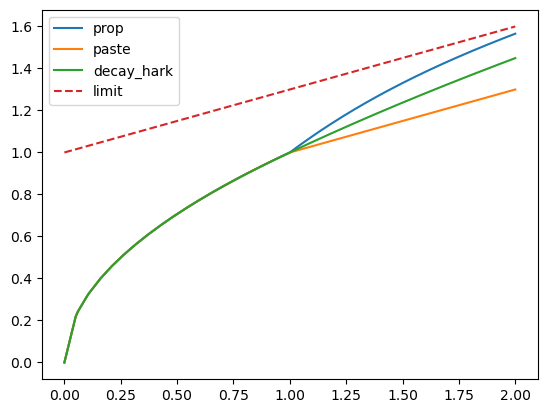

In [4]:
# Compare decay methods

x = np.linspace(0, 1, 20)
interp = LinearFast(np.sqrt(x), [x])


def limit_fun(x):
    return 1 + 0.3 * x


def limit_grad(x):
    return [0.3 * np.ones_like(x)]


dec_pr = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_prop",
)

dec_pa = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="paste",
)

dec_ha = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_hark",
)

x_ev = np.linspace(0, 2, 200)

plt.figure()
plt.plot(x_ev, dec_pr(x_ev), label="prop")
plt.plot(x_ev, dec_pa(x_ev), label="paste")
plt.plot(x_ev, dec_ha(x_ev), label="decay_hark")
plt.plot(x_ev, limit_fun(x_ev), "--", label="limit")
plt.legend()
plt.show()

## Comparing `econforge.DecayInterp` with `interpolation.LinearInterp`

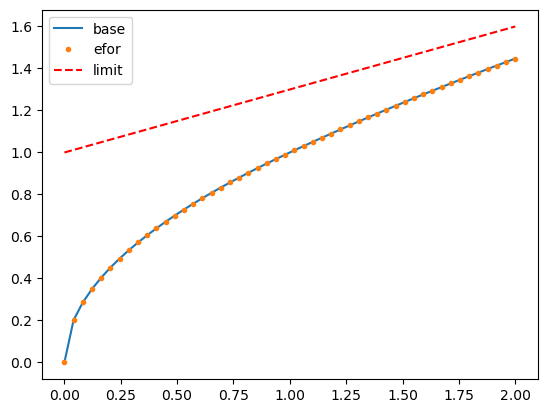

In [5]:
# Compare with base HARK
lim_slope = 0.3
lim_inter = 1.0

# Irregular grid
x = np.linspace(0, 1, 50)
y = np.sqrt(x)

# Hark's base implementation
base_lim_interp = LinearInterp(x, y, intercept_limit=lim_inter, slope_limit=lim_slope)

# New implementation
efor_lim_interp = DecayInterp(
    LinearFast(y, [x]),
    limit_fun=lambda x: lim_inter + lim_slope * x,
    limit_grad=lambda x: [lim_slope * np.ones_like(x)],
    extrap_method="decay_hark",
)

# Evaluate them
x_eval = np.linspace(0, 2, 50)
base_vals = base_lim_interp(x_eval)
efor_vals = efor_lim_interp(x_eval)

# Plot and compare
plt.figure()
plt.plot(x_eval, base_vals, label="base")
plt.plot(x_eval, efor_vals, ".", label="efor")
plt.plot(x_eval, lim_inter + x_eval * lim_slope, "--r", label="limit")
plt.legend()
plt.show()